In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import json
import sys

from pathlib import Path
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from functional import seq
import librosa
import seaborn as sns

sns.set_context("talk")

sys.path.append("..")
from GSSP_utils.path_conf import speech_data_session_dir, loc_data_dir
from GSSP_utils.conf import color_palette

pd.options.display.max_columns = None
pd.options.display.max_rows = 50


## Downloading all the data

- project: https://osf.io/8wrmn
- download and unzip the zips in the  `speech_web_app/backup` data directory
- make sure that you've set the the correct path to the data directory in the `data_dir` variable of [path_conf.py](../GSSP_utils/path_conf.py)


The folder structure:

```txt
web_app_data
|-- backup
|   |-- 2020-11-26__12:40:00+01:00__4949e55b-daff-4255-9741-3206033a736b
|   |   |-- PiSCES
|   |   |-- Radboud
|   |   |-- marloes
|   |   `-- metadata.json
|   |-- 2020-11-26__14:29:00+01:00__8fb4d923-48d0-4704-9c32-235c61227f76
|   |   |-- PiSCES
|   |   |-- Radboud
|   |   |-- marloes
|   |   `-- metadata.json
|   |-- 2020-11-26__16:20:00+01:00__b8b6a8ee-2b45-41e1-9d93-3eacbc25fc34
|   |   |-- PiSCES
|   |   |-- Radboud
|   |   |-- marloes
|   |   `-- metadata.json
|   |-- ...
```

In [19]:
# look at the data
!ls -lh {speech_data_session_dir} | head -n 10

total 0
drwxr-xr-x 5 jonas jonas 71 Aug  3  2022 2020-11-26__12_40_00+01_00__4949e55b-daff-4255-9741-3206033a736b
drwxr-xr-x 5 jonas jonas 71 Jun 27  2022 2020-11-26__14_29_00+01_00__8fb4d923-48d0-4704-9c32-235c61227f76
drwxr-xr-x 5 jonas jonas 71 Jun 27  2022 2020-11-26__16_20_00+01_00__b8b6a8ee-2b45-41e1-9d93-3eacbc25fc34
drwxr-xr-x 5 jonas jonas 71 Jun 27  2022 2020-11-26__18_50_00+01_00__33583a00-841f-4bef-b711-a8fe58c14476
drwxr-xr-x 5 jonas jonas 71 Jun 27  2022 2020-11-27__08_06_00+01_00__f46c79e9-7c35-4bd4-b384-078aeae84af7
drwxr-xr-x 5 jonas jonas 71 Jun 27  2022 2020-11-27__08_26_00+01_00__9223720f-1a2a-4811-84a1-a421646f63a0
drwxr-xr-x 5 jonas jonas 71 Jun 27  2022 2020-11-27__12_06_00+01_00__716dc108-5588-49ed-bf3c-04fb87212e2b
drwxr-xr-x 5 jonas jonas 71 Jun 27  2022 2020-11-27__12_24_00+01_00__99d276a0-83fe-4d47-949e-481dc67b2688
drwxr-xr-x 5 jonas jonas 71 Jun 27  2022 2020-11-27__16_37_00+01_00__b55d08fb-30f3-499f-8cf4-f0f44321f1a9
ls: write error: Broken pipe


In [20]:
# This snippet summarizes the dir-names of the various folders
# within `speech_data_session_dir`
dir_list = []
for folder in speech_data_session_dir.iterdir():
    if not folder.is_dir():
        continue
    dir_list.extend(
        seq(folder.iterdir())
        .filter(lambda x: x.is_dir())
        .map(lambda x: x.name)
        .to_list()
    )
print(pd.Series(dir_list).value_counts())
del dir_list, folder


Radboud    89
marloes    89
PiSCES     89
dtype: int64


## Parsing the `metadata.json` file

The `metadata.json` file resides within each user ID folder and withholds the users's 
metadata such as:
* gender
* age
* education
* used mic
* etc ...

In [21]:
metadata_dict_list = []

# creating alldata.csv
for folder in speech_data_session_dir.iterdir():
    if not folder.is_dir():
        continue

    metadata = folder.joinpath("metadata.json")
    if not metadata.is_file():
        continue

    with open(metadata, "r") as f:
        metadata_dict = json.load(f)
    metadata_dict["ID"] = folder.name.split("__")[-1]

    metadata_dict["Marloes"] = len(list(folder.joinpath("marloes").glob("*.wav")))
    metadata_dict["PiSCES"] = len(list(folder.joinpath("PiSCES").glob("*.wav")))
    metadata_dict["Radboud"] = len(list(folder.joinpath("Radboud").glob("*.wav")))

    metadata_dict_list.append(metadata_dict)

df_metadata = pd.DataFrame(metadata_dict_list)

# convert the columns to the correct data format
df_metadata["age"] = df_metadata["age"].astype(int)
df_metadata[["sex", "device", "education"]] = df_metadata[
    ["sex", "device", "education"]
].astype("category")
df_metadata["timestamp"] = pd.to_datetime(
    df_metadata.timestamp, utc=True
).dt.tz_convert("Europe/Brussels")

del folder, metadata_dict, metadata_dict_list, f, metadata
df_metadata.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype                          
---  ------          --------------  -----                          
 0   age             89 non-null     int64                          
 1   device          75 non-null     category                       
 2   education       89 non-null     category                       
 3   prolific_token  54 non-null     object                         
 4   sex             89 non-null     category                       
 5   timestamp       89 non-null     datetime64[ns, Europe/Brussels]
 6   ID              89 non-null     object                         
 7   Marloes         89 non-null     int64                          
 8   PiSCES          89 non-null     int64                          
 9   Radboud         89 non-null     int64                          
dtypes: category(3), datetime64[ns, Europe/Brussels](1), int64(4), ob

In [22]:
df_metadata["age"].describe().to_frame().round(2)


,age
count,89.00
mean,27.53
std,6.63
min,19.00
25%,23.00
50%,26.00
75%,30.00
max,53.00


## Participant metadata analysis

array([<AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>], dtype=object)

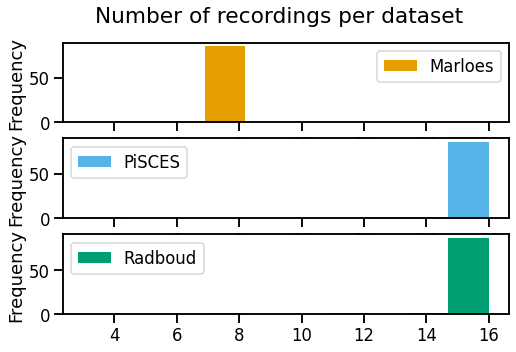

In [23]:
df_metadata[["Marloes", "PiSCES", "Radboud"]].plot(
    subplots=True,
    kind="hist",
    figsize=(8, 5),
    sharex=False,
    color=color_palette,
    title="Number of recordings per dataset",
)


In [24]:
# NOTE: as for now we do not filter on the number of recordings
df_metadata_relevant = (
    # df_metadata[
    # ~(
    #     (df_metadata.Marloes >= 6)
    #     & (df_metadata.Radboud >= 14)
    #     & (df_metadata.PiSCES >= 14)
    # )
    # ]
    df_metadata.reset_index(drop=True).copy()
)

df_metadata_relevant[
    ["age", "sex", "device", "Marloes", "PiSCES", "Radboud"]
].describe()


,age,Marloes,PiSCES,Radboud
count,89.000000,89.000000,89.000000,89.000000
mean,27.528090,6.932584,14.831461,14.865169
std,6.629976,0.330212,1.298915,0.906931
min,19.000000,5.000000,3.000000,7.000000
25%,23.000000,7.000000,15.000000,15.000000
50%,26.000000,7.000000,15.000000,15.000000
75%,30.000000,7.000000,15.000000,15.000000
max,53.000000,7.000000,16.000000,15.000000


In [25]:
print(
    f"{round(df_metadata_relevant.age.mean())}\t{round(df_metadata_relevant.age.std())}"
)


28	7


female    45
male      43
other      1
Name: sex, dtype: int64

----------------------------------------


pc-mic       36
headset      17
earphones    16
other         6
Name: device, dtype: int64

----------------------------------------


array([<AxesSubplot:ylabel='Frequency'>], dtype=object)

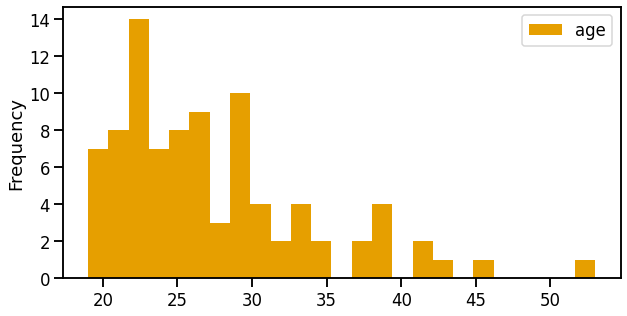

In [26]:
display(df_metadata_relevant.sex.value_counts())
print("-" * 40)
display(df_metadata_relevant.device.value_counts())
print("-" * 40)
df_metadata_relevant.education.value_counts()

# Also plot the distributions
df_metadata_relevant[["age"]].plot(
    kind="hist",
    subplots=True,
    sharex=False,
    figsize=(10, 5),
    backend="matplotlib",
    color=color_palette,
    bins=25,
)


## Extract recording info for each session

In [27]:
session_dict_list = []


# Iterate over each session
for folder in speech_data_session_dir.iterdir():
    if not folder.is_dir():
        continue

    def parse_pic_name_ts(db_folder, pic_name, time_str, sep="__") -> dict:
        """Get the arousal valence json for the corresponding description"""
        # what can we save from the wav file?
        json_f = sep.join([pic_name, time_str]) + ".json"
        json_f = db_folder.joinpath(json_f)
        if not json_f.is_file():
            # print('json_f does not exist')
            return {}

        with open(json_f, "r") as f:
            return json.load(f)

    def get_wav_json_mapping(db_folder: Path) -> dict:
        """Get the mapping from wav file to corresponding json (arousal/valence) file"""
        # parse the wav files to construct a dataframe
        wav_list = list(db_folder.glob("*.wav"))
        df_db_wav = pd.Series(
            seq(wav_list).map(lambda x: x.name), name="wav_files", dtype="str"
        ).to_frame()
        df_db_wav["wav_timestamp"] = (
            seq(wav_list)
            .map(
                lambda wav_file: pd.Timestamp(
                    wav_file.stat().st_mtime, unit="s", tz="Europe/Brussels"
                )
            )
            .to_list()
        )
        df_db_wav = df_db_wav.sort_values(by="wav_timestamp")

        # parse the json files to construct a dataframe
        json_list = list(db_folder.glob("*.json"))
        df_db_json = pd.Series(
            seq(json_list).map(lambda x: x.name), name="json_files", dtype="str"
        ).to_frame()
        df_db_json["json_timestamp"] = (
            seq(json_list)
            .map(
                lambda json_file: pd.Timestamp(
                    json_file.stat().st_mtime, unit="s", tz="Europe/Brussels"
                )
            )
            .to_list()
        )
        df_db_json = df_db_json.sort_values(by="json_timestamp")

        json_wav_mapping = pd.merge_asof(
            left=df_db_wav,
            right=df_db_json,
            left_on="wav_timestamp",
            right_on="json_timestamp",
            tolerance=pd.Timedelta(minutes=5),
            # A "forward" search selects the first row in the right DataFrame whose 'on' key
            # is greater than or equal to the left's key.
            direction="forward",
        )

        json_wav_mapping = json_wav_mapping.dropna(how="any", axis=0)
        json_wav_mapping = json_wav_mapping[
            ~(
                json_wav_mapping["wav_timestamp"]
                < json_wav_mapping["json_timestamp"].shift(1)
            )
        ].reset_index(drop=True)

        # Asserts to check that the merge is performed correctly
        assert all(
            (
                json_wav_mapping["json_timestamp"].shift(1)
                < json_wav_mapping["wav_timestamp"]
            ).values[1:]
        )
        wav_json_mapping_dict = (
            json_wav_mapping[["json_files", "wav_files"]]
            .set_index("wav_files")
            .to_dict()["json_files"]
        )
        return wav_json_mapping_dict

    # Iterate over each database folder
    for db_folder in [folder.joinpath(x) for x in ["marloes", "Radboud", "PiSCES"]]:
        wav_json_mapping_dict = get_wav_json_mapping(db_folder)

        for wav_file in db_folder.glob("*.wav"):
            pic_name, time_str = wav_file.name.split("__")
            metadata_dict = parse_pic_name_ts(db_folder, pic_name, time_str)
            metadata_dict["pic_name"] = pic_name
            metadata_dict["time_str"] = time_str.split(".")[0]
            metadata_dict["wav_size"] = wav_file.stat().st_size
            data, sample_rate = librosa.load(path=wav_file, sr=None)
            metadata_dict["wav_sample_rate"] = sample_rate
            metadata_dict["wav_duration_s"] = round(data.shape[0] / sample_rate, 2)
            ts = pd.Timestamp(wav_file.stat().st_mtime, unit="s", tz="Europe/Brussels")
            metadata_dict["wav_timestamp"] = ts + ts.utcoffset()
            metadata_dict["ID"] = db_folder.parent.name.split("__")[-1]
            metadata_dict["DB"] = db_folder.name[:1].upper() + db_folder.name[1:]

            # also read the json file to fetch the arousal and valence values
            if wav_file.name in wav_json_mapping_dict:
                with open(
                    db_folder.joinpath(wav_json_mapping_dict[wav_file.name]), "r"
                ) as f:
                    json_dct = json.load(f)
                    metadata_dict["arousal"] = int(json_dct.get("arousal"))
                    metadata_dict["valence"] = int(json_dct.get("valence"))

            session_dict_list.append(metadata_dict)

df_session = pd.DataFrame(session_dict_list)


# Sanity check - to see whether the wav_time_obj corresponds with the time_str
# there must be < 10 minutes of difference between the two
assert all(
    (
        df_session.apply(
            lambda r: r.wav_timestamp.replace(
                **dict(
                    zip(
                        ["hour", "minute", "second"],
                        list(map(int, r.time_str.split("_"))),
                    )
                )
            ),
            axis=1,
        )
        - df_session.wav_timestamp
    ).abs()
    < pd.Timedelta(minutes=10)
)


del folder, db_folder, wav_file, ts, metadata_dict, session_dict_list, time_str, f
del parse_pic_name_ts, pic_name, wav_json_mapping_dict, json_dct, data, sample_rate

display(df_session.sample(3))

print("-" * 88)

df_session_tot = df_metadata_relevant.merge(
    df_session, how="left", left_on="ID", right_on="ID"
)
display(df_session_tot.sample(3))

del df_session


,pic_name,time_str,wav_size,wav_sample_rate,wav_duration_s,wav_timestamp,ID,DB,arousal,valence
687,Picture 80,14_51_30,6709292,48000,69.89,2022-06-23 14:51:36+02:00,31e224eb-52af-4edf-b42b-a22960958dcf,PiSCES,30,55
1596,Rafd090_58_Caucasian_female_neutral_frontal,12_45_25,2727980,48000,28.42,2022-06-23 12:45:26+02:00,992fb536-7504-4c58-adaf-bd6498d96dc7,Radboud,22,75
1315,Picture 65,13_46_13,6660140,44100,75.51,2020-11-29 13:46:18+01:00,46914c9d-f87b-4ee5-aaf4-fe30d0ec272a,PiSCES,72,19


----------------------------------------------------------------------------------------


,age,device,education,prolific_token,sex,timestamp,ID,Marloes,PiSCES,Radboud,pic_name,time_str,wav_size,wav_sample_rate,wav_duration_s,wav_timestamp,DB,arousal,valence
3084,23,earphones,unif,5c5c3370dcea9700016e0bc4,male,2022-07-16 12:02:13.631034+02:00,271093f8-4d3f-4ee0-8a6e-faf9a61c83a4,7,15,15,Rafd090_36_Caucasian_male_neutral_frontal,12_24_58,4243500,48000,44.20,2022-07-16 12:24:58+02:00,Radboud,41,38
1821,23,pc-mic,ho,5eb9008b8224d385674c39b0,male,2022-06-29 18:55:57.528852+02:00,0e919efd-954e-4c12-98fb-dcf2d0a2b4e0,7,15,15,Rafd090_02_Caucasian_female_neutral_frontal,19_04_56,4063276,48000,42.33,2022-06-29 19:05:00+02:00,Radboud,68,81
905,21,headset,ho,n.a.,other,2022-07-28 09:56:59.413711+02:00,69a7b54c-9db3-4b35-9e85-dd2592c10a00,7,15,15,Picture 132,10_44_41,10125356,48000,105.47,2022-07-28 10:44:48+02:00,PiSCES,39,66


### Add the `DB_no` and `session_no` column

In [28]:
import numpy as np

# This is a simplified testcase to see whether the applied logic will work
test_arr = [1, 10, 3, 5, 2, 8, 100, 12, 200]
print(np.array(test_arr))
print(np.argsort(test_arr))
print(1 + np.argsort(np.argsort(test_arr)))


[  1  10   3   5   2   8 100  12 200]
[0 4 2 3 5 1 7 6 8]
[1 6 3 4 2 5 8 7 9]


In [29]:
df_session_tot["DB_no"] = df_session_tot.groupby(["ID", "DB"])["wav_timestamp"].apply(
    lambda s: 1 + s.argsort().argsort()
)
df_session_tot["session_no"] = df_session_tot.groupby(["ID"])["wav_timestamp"].apply(
    lambda s: 1 + s.argsort().argsort()
)

df_session_tot["pic_no"] = None
pic_mask = df_session_tot.DB != "Marloes"
df_session_tot.loc[pic_mask, "pic_no"] = (
    df_session_tot[pic_mask]
    .groupby(["ID"])
    .wav_timestamp.apply(lambda s: 1 + s.argsort().argsort())
)


In [30]:
# sort df session chronologically per user
df_session_tot = df_session_tot.sort_values(
    by=["ID", "wav_timestamp"], ignore_index=True
)

# In some rare cases, users got the same image twice; we remove the sessions where
# they got that image for the second time
duplicated_mask = df_session_tot.duplicated(subset=["ID", "pic_name"], keep="first") & (
    df_session_tot.DB != "Marloes"
)
display(duplicated_mask.value_counts())
df_session_tot = df_session_tot[~duplicated_mask].copy().reset_index(drop=True)
del duplicated_mask


False    3257
True        3
dtype: int64

## **Session analysis**: duration based visualizations

<AxesSubplot:ylabel='Frequency'>

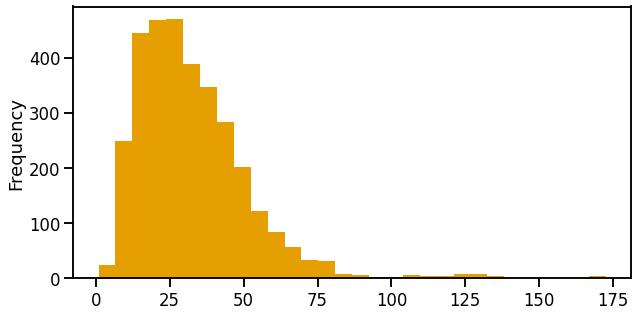

In [31]:
(
    (df_session_tot.wav_timestamp - df_session_tot.timestamp).dt.total_seconds() / 60
).plot.hist(color=color_palette, figsize=(10, 5), bins=30)


(-1.0, 120.0)

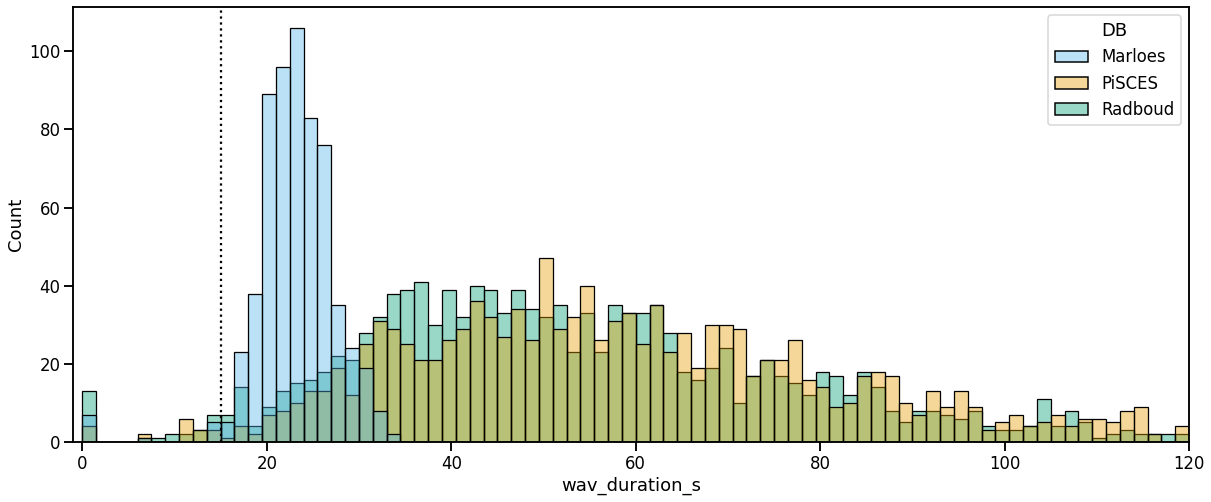

In [32]:
# A histogram of the recording durations (without checking for voicing)
fig, ax = plt.subplots(figsize=(20, 8))
sns.set_context("talk")
sns.histplot(
    data=df_session_tot,
    hue="DB",
    x="wav_duration_s",
    palette=color_palette[1:2] + color_palette[:1] + color_palette[2:3],
    # palette='Set3',
    ax=ax,
    alpha=0.4,
    bins=80,
    binrange=[0, 120],
)

ax.axvline(x=15, ls=":", c="black")
ax.set_xlim(-1, 120)


### Analyzing the sample rate

<AxesSubplot:>

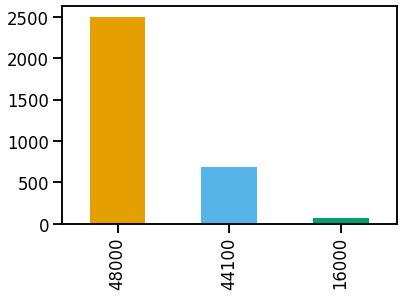

In [33]:
df_session_tot.wav_sample_rate.value_counts().plot.bar(color=color_palette)

since the recordings were performed on different days, the sample rate varies.

### Investigating the file duration

In [34]:
df_session_tot[
    (df_session_tot.wav_size > 400)
    & (df_session_tot.wav_duration_s < 15)
    & (df_session_tot.DB != "Marloes")
].groupby(["ID", "timestamp", "prolific_token", "DB"]).size().to_frame()


0
ID                                   timestamp                        prolific_token           DB         
9a725424-aafb-4d9b-8be7-acad80a46614 2022-07-27 14:55:01.266930+02:00 60fe5f65bf40c582873fefc2 Radboud   1
a2dbee10-fc31-42ec-89f8-9b4e5fa74b7f 2022-06-27 22:18:01.896264+02:00 5f2be3f5d81eaf0009520f8b PiSCES   14
                                                                                               Radboud  10
c30db4c2-a62a-4d69-8f1b-893a1f4b8c9d 2022-07-16 21:49:33.730743+02:00 5e360d610d43625c7da0a09d Radboud   1

`a2dbee10-fc31-42ec-89f8-9b4e5fa74b7f` has a lot of short segments => we will omit this users audio data. The valence/arousal data is still of interest though.

After auditory inspection, we could conclude that this user did not put any effort into the study.

### Parsing events

In [35]:
df_session_tot.sample(3)


,age,device,education,prolific_token,sex,timestamp,ID,Marloes,PiSCES,Radboud,pic_name,time_str,wav_size,wav_sample_rate,wav_duration_s,wav_timestamp,DB,arousal,valence,DB_no,session_no,pic_no
2836,20,pc-mic,so,5f58064bbb4b673607a4c7f4,male,2022-07-26 21:46:34.776329+02:00,e03516f6-1af7-4c72-ad49-41b6db4733d7,7,15,15,Rafd090_46_Caucasian_male_neutral_frontal,22_10_27,5087276,48000,52.99,2022-07-26 22:10:28+02:00,Radboud,77,53,6,15,12
894,29,headset,so,5beb4883e0a39400015430f5,male,2022-06-29 14:11:06.409834+02:00,42c842a5-7051-44c3-af42-cf824fded959,7,15,15,Picture 98,14_54_49,7249964,48000,75.52,2022-06-29 14:54:48+02:00,PiSCES,60,69,13,30,25
2995,27,pc-mic,unif,n.a.,female,2022-07-16 20:29:30.890814+02:00,effe47df-0f91-489d-8b7d-547f6fed85dd,7,15,15,Rafd090_33_Caucasian_male_neutral_frontal,21_24_56,4464684,44100,50.62,2022-07-16 21:25:14+02:00,Radboud,51,55,11,27,22


In [36]:
df_session_tot_cleaned = df_session_tot.copy()
df_session_tot_cleaned = df_session_tot_cleaned.sort_values(
    by=["ID", "wav_timestamp"], ignore_index=True
)
print(df_session_tot.shape)
display(df_session_tot_cleaned.shape)


(3257, 22)


(3257, 22)

In [37]:
# custom parsing
display(
    df_session_tot_cleaned[
        df_session_tot_cleaned.ID == "f57eb3a1-bc73-4fb8-9c40-8a31a6b67e34"
    ]
    .sort_values(by="wav_timestamp")[["session_no", "wav_timestamp", "DB"]]
    .iloc[:10]
)

# this user starts with pisces and has a total of 6 marloes instead of 7
# for some reason, the first marloes was not stored -> adjust the session_no and DB_no
df_session_tot_cleaned.loc[
    df_session_tot_cleaned.ID == "f57eb3a1-bc73-4fb8-9c40-8a31a6b67e34", "session_no"
] += 1
df_session_tot_cleaned.loc[
    (df_session_tot_cleaned.ID == ("f57eb3a1-bc73-4fb8-9c40-8a31a6b67e34"))
    & (df_session_tot_cleaned.DB == "Marloes"),
    "DB_no",
] += 1
display(
    df_session_tot_cleaned[
        df_session_tot_cleaned.ID == "f57eb3a1-bc73-4fb8-9c40-8a31a6b67e34"
    ]
    .sort_values(by="wav_timestamp")[["session_no", "wav_timestamp", "DB"]]
    .iloc[:10]
)


,session_no,wav_timestamp,DB
3147,1,2020-12-01 17:29:06+01:00,PiSCES
3148,2,2020-12-01 17:29:42+01:00,Radboud
3149,3,2020-12-01 17:30:44+01:00,PiSCES
3150,4,2020-12-01 17:31:22+01:00,Radboud
3151,5,2020-12-01 17:32:34+01:00,PiSCES
3152,6,2020-12-01 17:33:10+01:00,Marloes
3153,7,2020-12-01 17:33:52+01:00,Radboud
3154,8,2020-12-01 17:34:44+01:00,PiSCES
3155,9,2020-12-01 17:36:02+01:00,Radboud
3156,10,2020-12-01 17:36:40+01:00,PiSCES


,session_no,wav_timestamp,DB
3147,2,2020-12-01 17:29:06+01:00,PiSCES
3148,3,2020-12-01 17:29:42+01:00,Radboud
3149,4,2020-12-01 17:30:44+01:00,PiSCES
3150,5,2020-12-01 17:31:22+01:00,Radboud
3151,6,2020-12-01 17:32:34+01:00,PiSCES
3152,7,2020-12-01 17:33:10+01:00,Marloes
3153,8,2020-12-01 17:33:52+01:00,Radboud
3154,9,2020-12-01 17:34:44+01:00,PiSCES
3155,10,2020-12-01 17:36:02+01:00,Radboud
3156,11,2020-12-01 17:36:40+01:00,PiSCES


### Saving the session dataframe

In [38]:
df_session_tot_cleaned.to_parquet(
    loc_data_dir.joinpath("df_session_tot_cleaned.parquet")
)
